<a href="https://colab.research.google.com/github/ttezy/Time-Sequence-Analysis/blob/main/Performance_Evaluation/3.%20FB_Prophet_Multivariate_performance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Step 1: Load Data**

## **Import libraries**

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from datetime import datetime
import plotly.express as px
from sklearn.preprocessing import LabelEncoder


from fbprophet import Prophet

from sklearn.metrics import mean_squared_error
from math import sqrt

## **Load Dataset**

In [ ]:
df=pd.read_csv('pollution.csv',header=0, index_col=0)
df

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,NW,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,NW,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,NW,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,NW,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...
2014-12-31 19:00:00,8.0,-23,-2.0,1034.0,NW,231.97,0,0
2014-12-31 20:00:00,10.0,-22,-3.0,1034.0,NW,237.78,0,0
2014-12-31 21:00:00,10.0,-22,-3.0,1034.0,NW,242.70,0,0


## **Visualize the data**

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f50ca4055d0>,
      dtype=object)

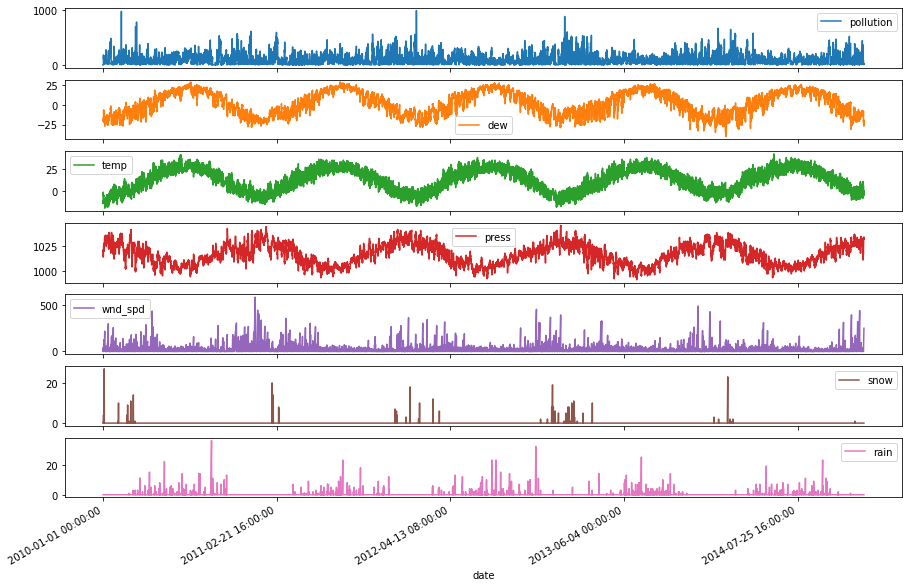

In [ ]:
df.plot(subplots=True, figsize=(15,10), legend=True)

# **Step 2: Preprocess the data**

## **Encode wind direction**

In [ ]:
values = df.values
# integer encode direction
encoder = LabelEncoder()
values[:, 4] = encoder.fit_transform(values[:, 4])
# ensure all data is float
values = values.astype('float32')

df['wnd_dir'] = values[:, 4]

df.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Rename "date" as "ds" and "pollution" with "y"**

In [ ]:
df_processed = df.reset_index().rename({'date':'ds', 'pollution':'y'}, axis='columns')
df_processed.head()

,ds,y,dew,temp,press,wnd_dir,wnd_spd,snow,rain
0,2010-01-01 00:00:00,0.0,-21,-11.0,1021.0,1.0,1.79,0,0
1,2010-01-01 01:00:00,0.0,-21,-12.0,1020.0,1.0,4.92,0,0
2,2010-01-01 02:00:00,0.0,-21,-11.0,1019.0,1.0,6.71,0,0
3,2010-01-01 03:00:00,0.0,-21,-14.0,1019.0,1.0,9.84,0,0
4,2010-01-01 04:00:00,0.0,-20,-12.0,1018.0,1.0,12.97,0,0


## **Reframe dataset for supervised learning**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in-1, -1, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i+1)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i-1)[0])
        if i == 0:
            names += ['var1(t)' ]
        else:
            names += [('var1(t+%d)' % (i))]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
pastStep = 24 # modify here to choose past steps
maxFutureStep = 24  # modify here to choose future steps
futureStep = 1

# frame as supervised learning
reframed = series_to_supervised(df.values, pastStep, futureStep)
reframed['ds'] = df_processed['ds'].shift(-1)[pastStep-1:]
reframed_processed = reframed.rename({'var1(t)':'y'}, axis='columns')


print(reframed_processed.shape)
print(reframed_processed.head())

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


(43800, 194)
    var1(t-24)  var2(t-24)  var3(t-24)  ...  var8(t-1)      y                   ds
23         0.0       -21.0       -11.0  ...        0.0  129.0  2010-01-02 00:00:00
24         0.0       -21.0       -12.0  ...        0.0  148.0  2010-01-02 01:00:00
25         0.0       -21.0       -11.0  ...        0.0  159.0  2010-01-02 02:00:00
26         0.0       -21.0       -14.0  ...        0.0  181.0  2010-01-02 03:00:00
27         0.0       -20.0       -12.0  ...        0.0  138.0  2010-01-02 04:00:00

[5 rows x 194 columns]


## **Split the train set and the test set**

In [ ]:
# use first 90% data to train
n_train_hours = int(len(df_processed) * 0.9)
train = reframed_processed[:n_train_hours]
test = reframed_processed[n_train_hours:]

y_true = test['y'].values
test = test.drop(['y'], axis=1)

print("train shape:", train.shape)
print("test shape:", test.shape)
print("y_true shape:", y_true.shape)

train shape: (39441, 194)
test shape: (4359, 193)
y_true shape: (4359,)


# **Step 3: Train prophet model and predict future 1 step by past 24 steps**

## **Train the model by using past 24 steps**

In [ ]:
model = Prophet(interval_width=0.95)

names = list()
for i in range(pastStep, 0, -1):
  names += [('var%d(t-%d)' % (j + 1, i)) for j in range(8)]

for variable in names:
  model.add_regressor(variable)

In [ ]:
model.fit(train)

In [ ]:
!pip install prophet

In [ ]:
import json
from prophet.serialize import model_to_json, model_from_json

with open('serialized_model.json', 'w') as fout:
    json.dump(model_to_json(model), fout)  # Save model

In [ ]:
with open('serialized_model.json', 'r') as fin:
    m = model_from_json(json.load(fin))  # Load model

## **Implement prediction**

In [ ]:
pd.set_option('mode.chained_assignment', None)

In [ ]:
maxFutureStep = 24
predSize = 200
prediction = np.array([])
for futureStep in range(1, maxFutureStep+1):
  print("futureStep: %2s"%futureStep)
  if futureStep == 1:
    result = m.predict(test)['yhat'].values
    prediction = np.array([result[:predSize]])
    print(prediction[0][:25])
  else:
    pred_group = np.array([])
    for i in range(0, predSize, futureStep): # e.g. futureStep = 3, i = 0
      test_group = test.iloc[i:i+futureStep]   
      #print("i:%2s"%i)
      #print(test_group)
      pred_temp = np.array([])
      for j in range(0, futureStep):    #e.g. j = 0, 1, 2, 3 in a group
        test_temp = test_group.iloc[[j]]
        #print("j:%2s"%j)
        if j == 0:
          pred_temp = np.array([m.predict(test_temp)['yhat'].values])
        else:
          for k in range(j, 0, -1):   # e.g. j = 3, k = 1, 2, 3  
            test_temp.iloc[0, -1-8*k] = pred_temp[j-k]
          pred_temp = np.append(pred_temp, m.predict(test_temp)['yhat'].values)
      if i == 0:
        pred_group = np.array(pred_temp)
      else:
        pred_group = np.append(pred_group, pred_temp)
      #print(test_temp.iloc[0, -9:])
      #print(pred_group)
    prediction = np.append(prediction, np.array([pred_group[:predSize]]), axis = 0)
    print(pred_group[:25])

futureStep:  1
[250.88162005 267.26609548 264.43836046 262.95855884 245.41976419
 221.2936114  203.1708797  172.61714475 168.44398028 162.73095064
 161.57232004 153.54283927 153.91539907 206.00529177 234.85337014
 246.39049148 287.06614533 278.35249994 281.48798767 283.23661401
 270.35471347 259.0648231  245.46393344 215.5040414  185.10079435]
futureStep:  2
[250.88162005 240.68138004 264.43836046 254.22890195 245.41976419
 233.54568767 203.1708797  196.51082946 168.44398028 164.04928651
 161.57232004 164.10822223 153.91539907 158.45270481 234.85337014
 232.56180852 287.06614533 274.76093999 281.48798767 263.59641674
 270.35471347 249.3458101  245.46393344 233.27436835 185.10079435]
futureStep:  3
[250.88162005 240.68138004 231.00526774 262.95855884 251.77284107
 239.41160121 203.1708797  196.51082946 188.32994489 162.73095064
 163.15265625 165.56737591 153.91539907 158.45270481 162.64940641
 246.39049148 242.68627412 233.78418309 281.48798767 263.59641674
 243.30670676 259.0648231  24

## **Save prediction result to the file**

In [ ]:
pd.DataFrame(prediction).to_csv('/content/Prophet_prediction.csv')

## **Calculate RMSE**

Test RMSE of future step  1: 15.635
Test RMSE of future step  2: 20.278
Test RMSE of future step  3: 24.225
Test RMSE of future step  4: 26.993
Test RMSE of future step  5: 28.600
Test RMSE of future step  6: 33.888
Test RMSE of future step  7: 32.227
Test RMSE of future step  8: 32.730
Test RMSE of future step  9: 34.879
Test RMSE of future step 10: 40.415
Test RMSE of future step 11: 43.183
Test RMSE of future step 12: 48.213
Test RMSE of future step 13: 36.670
Test RMSE of future step 14: 40.921
Test RMSE of future step 15: 42.979
Test RMSE of future step 16: 38.555
Test RMSE of future step 17: 38.164
Test RMSE of future step 18: 37.815
Test RMSE of future step 19: 47.283
Test RMSE of future step 20: 48.348
Test RMSE of future step 21: 40.841
Test RMSE of future step 22: 40.970
Test RMSE of future step 23: 43.008
Test RMSE of future step 24: 47.725


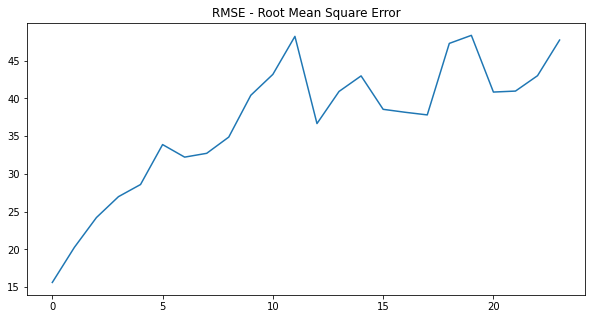

In [ ]:
RMSE = np.array([])
for i in range(maxFutureStep):
  rmse = sqrt(mean_squared_error(prediction[i][:predSize], y_true[:predSize]))
  print('Test RMSE of future step %2s: %.3f' % (i+1, rmse))
  RMSE = np.append(RMSE, rmse)

plt.figure(figsize=(10,5))
plt.plot(RMSE)
plt.title("RMSE - Root Mean Square Error")
plt.show()

## **Show prediction results**

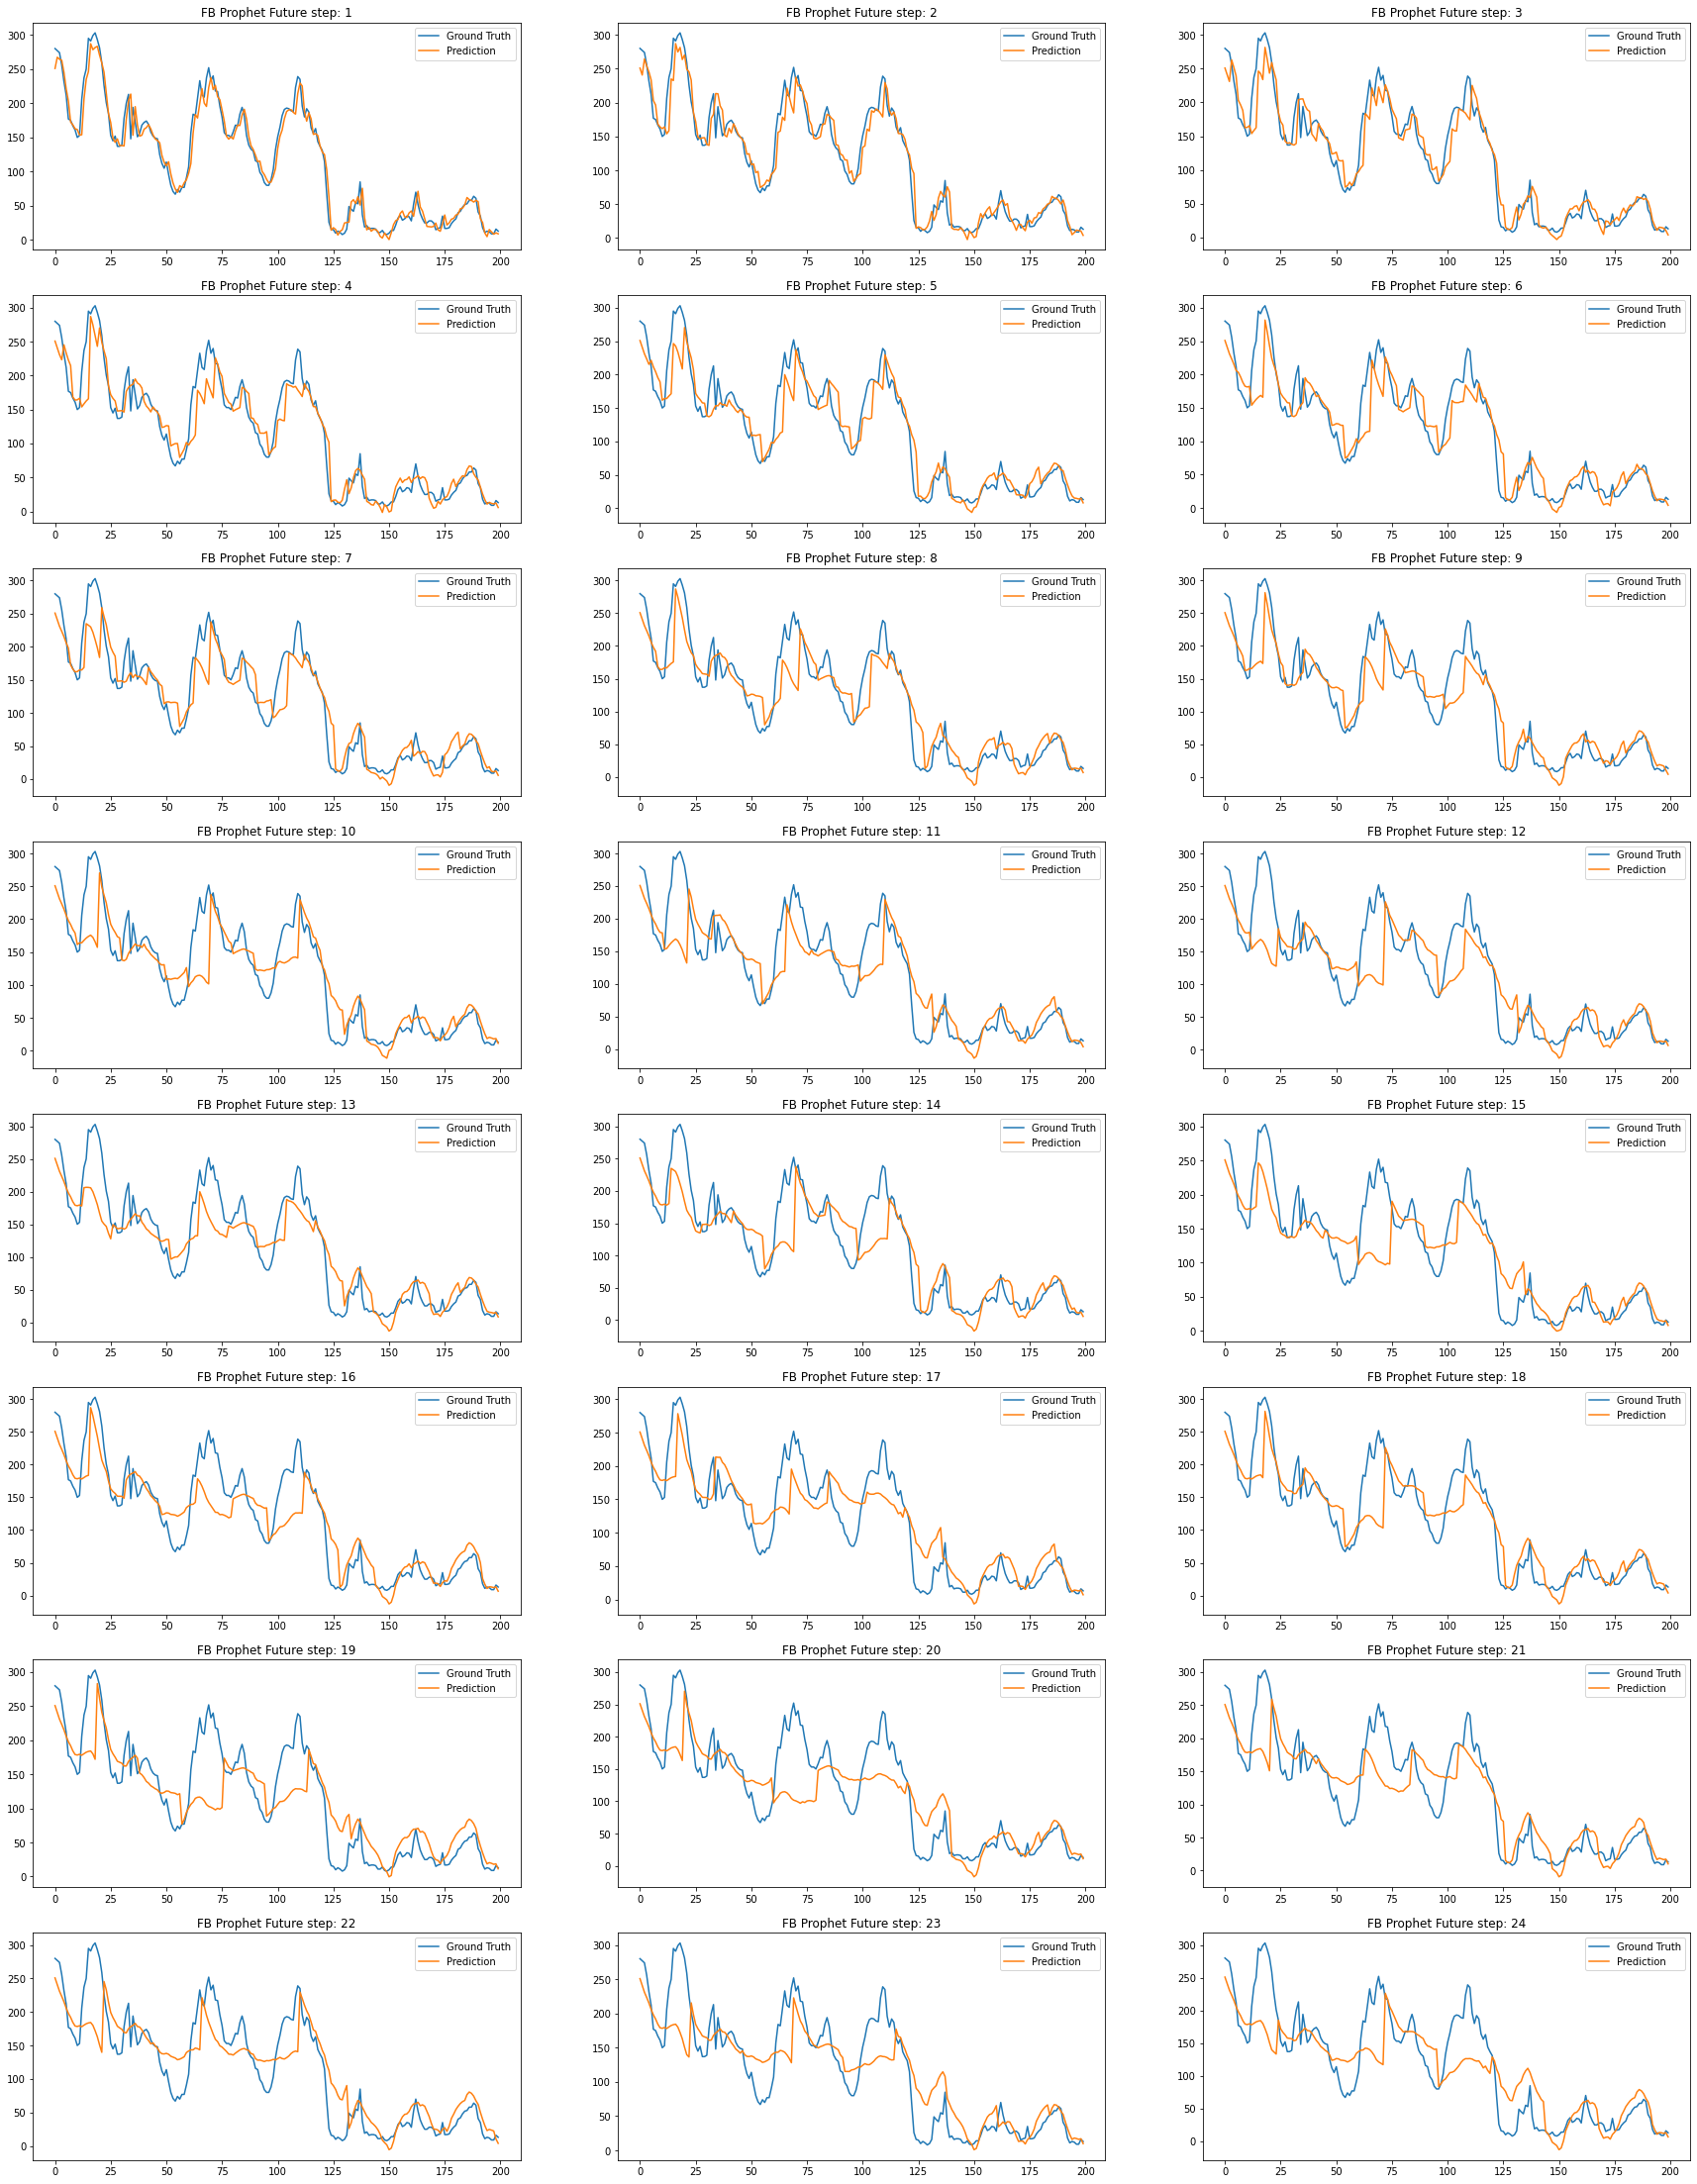

In [ ]:
plt.figure(figsize=(30,60))
for i in range(maxFutureStep):
  plt.subplot(12, 3, i+1)
  plt.plot(y_true[:predSize], label='Ground Truth')
  plt.plot(prediction[i][:predSize], label='Prediction')
  plt.title("FB Prophet" + " Future step: " + str(i+1))
  plt.legend()
plt.show()

# **Evaluate Time and RMSE**

The following work is used to evaluate the time and RMSE by using the pre-saved files 'performance' and 'prediction'. 

In [ ]:
performance = pd.read_csv('/content/performance.csv', header=0, index_col=0)

In [ ]:
prediction = pd.read_csv('/content/Prophet_prediction.csv', header=0, index_col=0)

In [ ]:
prediction = np.array(prediction.values)

In [ ]:
predSize = 200
RMSE = np.array([])
for i in range(24):
  rmse = sqrt(mean_squared_error(prediction[i][:predSize], y_true[:predSize]))
  print('Test RMSE of future step %2s: %.3f' % (i+1, rmse))
  RMSE = np.append(RMSE, rmse)

Test RMSE of future step  1: 15.635
Test RMSE of future step  2: 20.278
Test RMSE of future step  3: 24.225
Test RMSE of future step  4: 26.993
Test RMSE of future step  5: 28.600
Test RMSE of future step  6: 33.888
Test RMSE of future step  7: 32.227
Test RMSE of future step  8: 32.730
Test RMSE of future step  9: 34.879
Test RMSE of future step 10: 40.415
Test RMSE of future step 11: 43.183
Test RMSE of future step 12: 48.213
Test RMSE of future step 13: 36.670
Test RMSE of future step 14: 40.921
Test RMSE of future step 15: 42.979
Test RMSE of future step 16: 38.555
Test RMSE of future step 17: 38.164
Test RMSE of future step 18: 37.815
Test RMSE of future step 19: 47.283
Test RMSE of future step 20: 48.348
Test RMSE of future step 21: 40.841
Test RMSE of future step 22: 40.970
Test RMSE of future step 23: 43.008
Test RMSE of future step 24: 47.725


In [ ]:
import time

# model = Prophet(interval_width=0.95)

# names = list()
# for i in range(24, 0, -1):
#   names += [('var%d(t-%d)' % (j + 1, i)) for j in range(8)]

# for variable in names:
#   model.add_regressor(variable)

# train_time = np.zeros(24)
# tic = time.perf_counter()
# model.fit(train)
# toc = time.perf_counter()
# train_time.fill(toc-tic)

pred_time = np.array([])
for i in range(0, 24):
  tic = time.perf_counter()
  model.predict(test.iloc[:i+1])
  toc = time.perf_counter()
  pred_time = np.append(pred_time, toc-tic)

print(train_time)
print(pred_time)

[444.15818045 444.15818045 444.15818045 444.15818045 444.15818045
 444.15818045 444.15818045 444.15818045 444.15818045 444.15818045
 444.15818045 444.15818045 444.15818045 444.15818045 444.15818045
 444.15818045 444.15818045 444.15818045 444.15818045 444.15818045
 444.15818045 444.15818045 444.15818045 444.15818045]
[2.8279078  2.7831156  2.76074349 2.86475856 2.91482386 2.74464837
 2.94813916 2.74076323 2.85871819 2.75730831 2.70651532 2.79470641
 2.97788361 2.73001156 2.76898343 2.93496734 2.83112927 2.87028822
 2.94347859 2.88086029 2.8334488  2.91274131 2.90753935 2.8506382 ]


In [ ]:
performance['Prophet_train_time'] = train_time
performance['Prophet_pred_time'] = pred_time
performance['Prophet_RMSE'] = RMSE
performance.to_csv('/content/performance.csv')
performance

,futureStep,LSTM_train_time,LSTM_pred_time,LSTM_RMSE,VAR_train_time,VAR_pred_time,VAR_RMSE,Prophet_train_time,Prophet_pred_time,Prophet_RMSE
0,1,105.876651,0.585758,35.255931,0.751379,0.000739,21.579288,444.15818,2.827908,15.635074
1,2,87.481275,0.531446,17.962829,0.751379,0.004411,26.454463,444.15818,2.783116,20.277924
2,3,90.200571,0.586707,23.689260,0.751379,0.000437,30.682874,444.15818,2.760743,24.225334
3,4,87.507864,0.497406,36.814017,0.751379,0.000547,34.570659,444.15818,2.864759,26.992872
4,5,144.578841,0.550200,44.236213,0.751379,0.000600,38.027382,444.15818,2.914824,28.599872
5,6,144.036165,0.581201,52.304478,0.751379,0.003270,40.791843,444.15818,2.744648,33.888291
6,7,87.991832,0.540688,57.936118,0.751379,0.000748,43.828483,444.15818,2.948139,32.226575
7,8,87.094941,0.504986,62.433286,0.751379,0.002128,49.305543,444.15818,2.740763,32.730049
8,9,144.055997,0.535396,67.367820,0.751379,0.002578,48.388991,444.15818,2.858718,34.879333
9,10,95.500659,0.585587,72.387994,0.751379,0.002761,50.566161,444.15818,2.757308,40.414856
